# Big Data in Finance: Part II (Lecture 1) <BR><BR> Lecture Notes 2: Compustat 
    
**Instructor** <BR>
Lira Mota, lmota20@gsb.columbia.edu
    
**TA's:** <BR>
Pu He, phe19@gsb.columbia.edu <BR> Daheng Yang, dyang22@gsb.columbia.edu

**Objective**

Create a data frame with company fundamentals necessary to replicate FF 2015:

1. Book Equity (BE)
2. Operating Profits (OP)
3. Investment (INV)

# Set Up

In [1]:
%matplotlib inline 

#%% Packages 
import wrds
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 6]

import time
from time import strptime, strftime

# Setups
pd.set_option("display.max_rows", 100) # max number or rows to be displayed 

In [2]:
#%% Set WRDS Connection
db = wrds.Connection(wrds_username='lmota') # make sure to configure wrds connector before hand.

Loading library list...
Done


# Choose variables of interest

Compustat XpressFeed Variables 1/5:  
* AT      = Total Assets  
* CAPX    = Capital Expenditures  
* CEQ     = Common/Ordinary Equity - Total 
* COGS    = Cost of Goods Sold
* CSHO    = Common Shares Outstanding
* DLC     = Debt in Current Liabilities 
* DLCCH   = Current Debt - Changes
* DLTT    = Long-Term Debt - Total

Compustat XpressFeed Variables 2/5:
* DP      = Depreciation and Amortization
* DVC     = Divdends common/ordinary  
* DVP     = Dividends - Preferred/Preference
* GP      = Gross Profits
* IB      = Income Before Extraordinary Items
* ICAPT   = Invested Capital - Total
* ITCB    = Investment Tax Credit (Balance Sheet)  
* LT      = Total Liabilities

Compustat XpressFeed Variables 3/5:
* MIB     = Minority Interest (Balance Sheet)
* NAICS   = North American Industrial Classification System Variable Name
* NAICSH  = North American Industry Classification Codes - Historical Company Variable Name
* NI      = Net Income
* PPEGT   = "Property, Plant and Equipment - Total (Gross)"
* PRBA    = Postretirement Benefit Assets (from separate pension annual file) 
* PRSTKCC = Purchase of Common Stock (Cash Flow)                   
* PSTKRV  = Preferred Stock Redemption Value

Compustat XpressFeed Variables 4/5:
* PSTK    = Preferred/Preference Stock (Capital) - Total (kd: = par?)               
* PSTKL   = Preferred Stock Liquidating Value     
* PSTKRV  = Preferred Stock Liquidating Value          
* RE      = Retained Earnings
* REVT    = Revenue - Total
* SALE    = Sales/Turnover Net
* SEQ     = Shareholders Equity   
* SIC     = Standard Industrial Classification Code

Compustat XpressFeed Variables 5/5:
* TXDB    = Deferred Taxes Balance Sheet
* TXDI    = Income Taxes - Deferred
* TXDITC  = Deferred Taxes and Investment Tax Credit                        
* WCAPCH  = Working Capital Change - Total
* XINT    = Interest and Related Expense - Total 
* XLR     = Staff Expense - Total
* XRD     = Research and Development Expense 
* XSGAQ   = Selling, General and Administrative Expenses (millions)  

# Download Compustat FUNDA

In [2]:
fund_table = 'funda'

varlist = ['conm', 'fyear', 'fyr', 'at','capx', 'ceq', 'cogs', 'csho', 'dlc', 'dlcch','dltt', 'dp', 'ib', 'itcb', 
           'lt', 'mib', 'naicsh', 'ni', 'prstkcc', 'pstk', 'pstkl', 'pstkrv', 're', 'revt', 'sale', 
           'seq', 'sich', 'txdb', 'txdi', 'txditc', 'wcapch', 'xint', 'xlr', 'xrd', 'xsga']


query = """SELECT gvkey, datadate, {}
           FROM compd.{}
           WHERE datafmt = 'STD'
           AND popsrc = 'D'
           AND indfmt = 'INDL'
           AND consol = 'C'
           AND fyear>=1980;""".format(", ".join(varlist), fund_table)

compa = db.raw_sql(query, date_cols=['datadate'])

del(fund_table, varlist, query)

NameError: name 'db' is not defined

Always look at your data

In [4]:
# Gerneral Look
compa.head() 

,gvkey,datadate,conm,fyear,fyr,at,capx,ceq,cogs,csho,...,seq,sich,txdb,txdi,txditc,wcapch,xint,xlr,xrd,xsga
0,001001,1980-12-31,A & M FOOD SERVICES INC,1980.0,12.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,001001,1981-12-31,A & M FOOD SERVICES INC,1981.0,12.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,001001,1982-12-31,A & M FOOD SERVICES INC,1982.0,12.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,001001,1983-12-31,A & M FOOD SERVICES INC,1983.0,12.0,14.080,3.367,7.823,6.310,3.568,...,7.823,NaN,0.000,0.144,0.000,3.618,0.763,NaN,0.0,16.435
4,001001,1984-12-31,A & M FOOD SERVICES INC,1984.0,12.0,16.267,5.496,8.962,8.171,3.568,...,8.962,NaN,0.357,0.275,0.357,-2.993,0.661,NaN,NaN,20.628


In [3]:
# Have a sense about missings
compa['at'].isnull().mean()*100

NameError: name 'compa' is not defined

# Data Consistency 

## Primary Keys


* We are looking at Annual data
* Logic says that that we should have one company (gvkey) per year (fyear)
* But remember, the primary key for funda is (gvkey and datadate)
* Question: Can a firm have two datadate for the same year?


In [6]:
# It is always good to check if we have the right PK
compa.duplicated(['gvkey', 'datadate']).sum()

0

In [7]:
# Is (gvkey, fyear) PK?
compa.duplicated(['gvkey', 'fyear']).sum()

2

In [8]:
# Check duplicates
compa[compa.duplicated(['gvkey', 'fyear'],keep='last')]

,gvkey,datadate,conm,fyear,fyr,at,capx,ceq,cogs,csho,...,seq,sich,txdb,txdi,txditc,wcapch,xint,xlr,xrd,xsga
64260,006557,1982-08-31,LAIDLAW INTERNATIONAL INC,1982.0,8.0,251.360,47.089,63.491,213.686,11.584,...,84.314,NaN,19.938,2.672,19.938,13.777,14.309,NaN,NaN,NaN
64262,006557,1983-08-31,LAIDLAW INTERNATIONAL INC,1983.0,8.0,328.891,78.264,103.481,232.581,26.168,...,120.161,NaN,25.469,5.533,25.469,3.109,8.879,NaN,NaN,17.218


In [9]:
# Example of a company that have two reports for the same year
compa.loc[compa.gvkey=='006557',['gvkey','datadate','fyear','fyr','conm', 'at']]

,gvkey,datadate,fyear,fyr,conm,at
64258,006557,1980-08-31,1980.0,8.0,LAIDLAW INTERNATIONAL INC,201.266
64259,006557,1981-08-31,1981.0,8.0,LAIDLAW INTERNATIONAL INC,242.081
64260,006557,1982-08-31,1982.0,8.0,LAIDLAW INTERNATIONAL INC,251.360
64261,006557,1982-12-31,1982.0,12.0,LAIDLAW INTERNATIONAL INC,NaN
64262,006557,1983-08-31,1983.0,8.0,LAIDLAW INTERNATIONAL INC,328.891
64263,006557,1983-12-31,1983.0,12.0,LAIDLAW INTERNATIONAL INC,NaN
64264,006557,1984-08-31,1984.0,8.0,LAIDLAW INTERNATIONAL INC,426.880
64265,006557,1985-08-31,1985.0,8.0,LAIDLAW INTERNATIONAL INC,652.477
64266,006557,1986-08-31,1986.0,8.0,LAIDLAW INTERNATIONAL INC,901.769
64267,006557,1987-08-31,1987.0,8.0,LAIDLAW INTERNATIONAL INC,1655.019


In [10]:
# How to deal with duplicates? Keep last available entry (datadate)
compa.dropna(subset=['fyear'], inplace=True)
compa.sort_values(['gvkey','fyear','at'], inplace=True)
compa = compa[~compa.duplicated(['gvkey', 'fyear'], keep='first')]

In [11]:
# Always check your result
compa.duplicated(['gvkey', 'fyear']).sum()

0

# Calculate Variables of Interest

## Book Equity

Daniel, Mota, Rottke, Santos (2018) BE definition:

Stockholders book equity, minus the book value of preferred stock, plus balance sheet deferred taxes (if available and fiscal year is < 1993), minus investment tax credit (if available), minus post-retirement benefit assets (PRBA) if available. 

Stockholders book equity is shareholder equity (SEQ), common equity (CEQ) plus preferred stock (PSTK) or total
assets (AT) minus liabilities (LT) plus minority interest (MIB, if available) (depending on availability, in that order). 

Book value of preferred stock is redemption (PSTKRV), liquidation (PSTKL), or par value (PSTK) (depending on availability, in that order). 

Deferred taxes is deferred taxes and investment tax credit (TXDITC) or deferred taxes and investment tax credit (TXDB) plus investment tax credit (ITCB) (depending on availability, in that order).


In [12]:
#%% Calculating BE

# Shareholder Equity
compa['se'] = compa['seq']

# Uses Common Equity (ceq) + Preferred Stock (pstk) if SEQ is missing:
compa['se'].fillna((compa['ceq'] + compa['pstk']), inplace=True)

# Uses Total Assets (at) - Liabilities (lt) + Minority Interest (mib, if available), if others are missing
compa['se'].fillna((compa['at'] - compa['lt'] + compa['mib'].fillna(0)), inplace=True)


In [13]:
# Preferred Stock
# Preferred Stock (Redemption Value)
compa['ps'] = compa['pstkrv']
# Uses Preferred Stock (Liquidating Value (pstkl)) if Preferred Stock (Redemption Value) is missing
compa['ps'].fillna(compa['pstkl'], inplace=True)
# Uses Preferred Stock (Carrying Value (pstk)) if others are missing
compa['ps'].fillna(compa['pstk'], inplace=True)

In [14]:
# Deferred Taxes
# Uses Deferred Taxes and Investment Tax Credit (txditc)
compa['dt'] = compa['txditc']

# This was Novy-Marx old legacy code. We drop this part to be in accordance with Ken French.
# Uses Deferred Taxes and Investment Tax Credit(txdb) + Investment Tax Credit (Balance Sheet) (itcb) if txditc is missing
compa['dt'].fillna((compa['txdb'].fillna(0) + compa['itcb'].fillna(0)), inplace=True)
# If all measures are missing, set n  to missing
compa.loc[pd.isnull(compa['txditc']) & pd.isnull(compa['txdb']) & pd.isnull(compa['itcb']), 'dt'] = np.nan

compa.loc[compa['fyear'] >= 1993, 'dt'] = 0

In [15]:
# Book Equity
# Book Equity (BE) = Share Equity (se) - Prefered Stocks (ps) + Deferred Taxes (dt)
compa['be'] = (compa['se']  # shareholder equity must be available, otherwise BE is missing
               - compa['ps']  # preferred stock must be available, otherwise BE is missing
               + compa['dt'].fillna(0))  # add deferred taxes if available
               #- compa['prba'].fillna(0))  # subtract postretirement benefit assets if available

**Always look at your data...**

In [16]:
# Missings
compa.be.isnull().mean()

0.15532350059787026

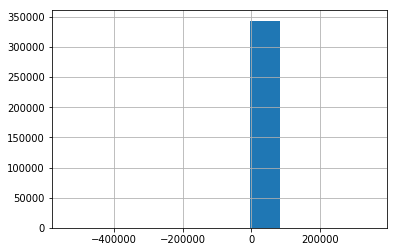

In [17]:
compa.be.hist() 

In [18]:
# Does it make sense to have a negative BE?
(compa.be<0).mean()  

0.09676167934020659

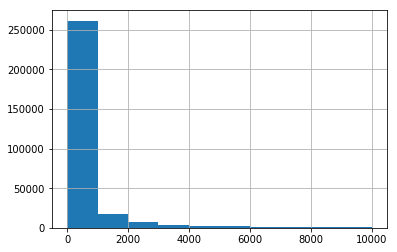

In [19]:
compa[(compa.be>0)&(compa.be<10e3)].be.hist()

## Operating Profitability (OPBE)

Daniel, Mota, Rottke, Santos (2018) OPBE definition:

Operating profits to book equity (BE) ratio. 

Operating profits is sales (SALE) minus cost of goods sold (COGS), minus selling, general, and administrative expenses (XSGA),
minus interest expense (XINT). In order to be non-missing, SALE must be non-missing, at least one of the other entries must be non-missing and BE must be greater than zero.

In [20]:
# COST = COGS + XSGA - XINT 
compa['cost'] = compa[['cogs', 'xsga', 'xint']].sum(axis=1, skipna=True)
compa.loc[compa[['cogs', 'xsga', 'xint']].isnull().all(axis=1), 'cost'] = np.nan

In [21]:
# OP = SALE -COST    
compa['op'] = compa['sale']-compa['cost']

**Always look at your data...**

In [22]:
# Look at missings
compa.op.isnull().mean()

0.15947053494042168

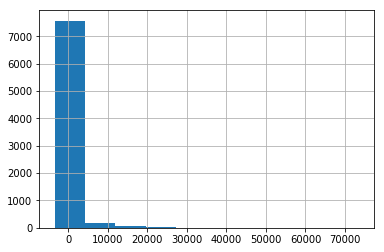

In [23]:
compa[compa.fyear==2017].op.hist()

In [24]:
# Which was the most profitable company in 2017?
compa.loc[compa[compa.fyear==2018].op.idxmax(),['gvkey','conm','op','be','at']]

gvkey       001690
conm     APPLE INC
op           78325
be          107147
at          365725
Name: 7924, dtype: object

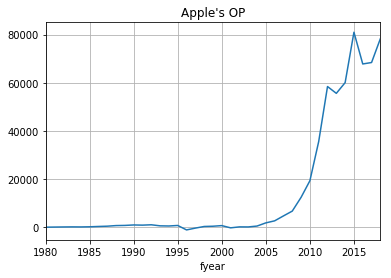

In [25]:
# Plot
compa[compa.gvkey=='001690'].set_index('fyear').op.plot(title = "Apple's OP", grid=True)

In [26]:
# Calculate OPBE
compa.loc[(compa.be > 0), 'opbe'] = compa['op']/compa['be']

**What do we do now?**

Look at the data...

In [27]:
# Look at missings
compa.opbe.isnull().mean()

0.25792147397729814

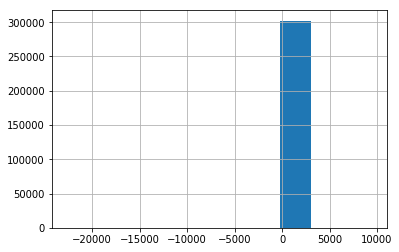

In [28]:
# Be careful with ratios
compa.opbe.hist()

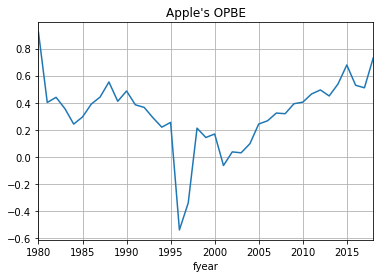

In [29]:
# Plot
compa[compa.gvkey=='001690'].set_index('fyear').opbe.plot(title = "Apple's OPBE", grid=True)

## Investment (INV)

Daniel, Mota, Rottke, Santos (2018) OP definition:

Total asset (AT) growth $(AT_t/AT_{t-1} - 1)$. 

We consider PERMCO as company's identification key. AT must be greater than zero to be not missing.


In [30]:
# Calculate lag assets and investment
compa.sort_values(['gvkey', 'fyear'], inplace=True)
compa['at_lag'] = compa.groupby('gvkey').at.shift(1)
compa['inv'] = (compa['at'] - compa['at_lag']) / compa['at_lag']

What if compa has missing years?

In [31]:
compa['fdiff'] = compa.groupby('gvkey').fyear.diff()

In [32]:
compa[(compa.fdiff>1)][['gvkey','fyear','at','at_lag', 'inv']]

,gvkey,fyear,at,at_lag,inv
20765,002820,2001.0,117.090,NaN,NaN
26551,003279,2011.0,NaN,1.269,NaN
28590,003469,2002.0,406.677,NaN,NaN
32365,003819,2011.0,NaN,2.295,NaN
35004,004049,2000.0,905.890,NaN,NaN
38601,004341,2000.0,0.000,NaN,NaN
39342,004412,2004.0,213.432,218.681,-0.024003
39345,004412,2008.0,219.640,203.755,0.077961
42904,004707,1996.0,14.416,NaN,NaN
48485,005202,1999.0,0.000,0.102,-1.000000


In [33]:
# Check one case of skipping years
compa.loc[compa.gvkey=='005681',['gvkey','fyear','at','at_lag','inv','fdiff']]

,gvkey,fyear,at,at_lag,inv,fdiff
53657,005681,1983.0,6803.074,NaN,NaN,NaN
53674,005681,1984.0,8885.500,6803.074,0.306101,1.0
53681,005681,1985.0,10018.598,8885.500,0.127522,1.0
53691,005681,1986.0,12074.598,10018.598,0.205218,1.0
53694,005681,1987.0,14109.098,12074.598,0.168494,1.0
53697,005681,1988.0,17008.699,14109.098,0.205513,1.0
52452,005681,1989.0,17766.699,17008.699,0.044565,1.0
53026,005681,1990.0,18259.500,17766.699,0.027737,1.0
53549,005681,1991.0,13885.098,18259.500,-0.239569,1.0
53711,005681,1995.0,26.851,13885.098,-0.998066,4.0


In [34]:
# Input missings
filter_inv = (compa['at']<=0)|(compa['at_lag']<=0)|(compa.fdiff>1)
compa.loc[filter_inv,['inv']] = np.nan
del(filter_inv)

In [35]:
# Check one case of skipping years (again)
compa.loc[compa.gvkey=='005681',['gvkey','fyear','at','at_lag','inv']]

,gvkey,fyear,at,at_lag,inv
53657,005681,1983.0,6803.074,NaN,NaN
53674,005681,1984.0,8885.500,6803.074,0.306101
53681,005681,1985.0,10018.598,8885.500,0.127522
53691,005681,1986.0,12074.598,10018.598,0.205218
53694,005681,1987.0,14109.098,12074.598,0.168494
53697,005681,1988.0,17008.699,14109.098,0.205513
52452,005681,1989.0,17766.699,17008.699,0.044565
53026,005681,1990.0,18259.500,17766.699,0.027737
53549,005681,1991.0,13885.098,18259.500,-0.239569
53711,005681,1995.0,26.851,13885.098,NaN


**What do we do now?**

In [36]:
# Look at missings
compa.inv.isnull().mean()

0.23697760012178384

In [37]:
# Be careful with ratios
compa.loc[compa.inv.idxmax,['gvkey','fyear','at','at_lag','inv']]

gvkey      018073
fyear        2013
at        427.398
at_lag      0.001
inv        427397
Name: 185641, dtype: object

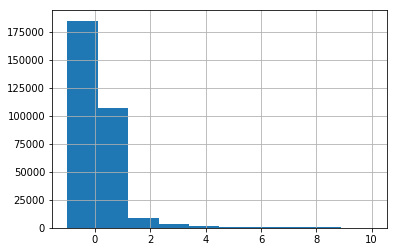

In [38]:
# What explains such large inv?
compa[compa.inv<10].inv.hist()

# Is Asset Growth Investment?

* See Cooper, Gulen, Schill, JF (2008);
* What is asset growth capturing other than investment? 
    * Mergers;
    * Issuance;
    * Spin-offs.
* Is it really investments that forecast future stock returns?

In [39]:
# A more traditional measure of investment: CAPX
compa['inv_capx'] = compa['capx']/compa['at_lag']
filter_inv_capx = (compa['capx']<=0)|(compa['at_lag']<=0)|(compa.fdiff>1)
compa.loc[filter_inv_capx,'inv_capx']=np.nan

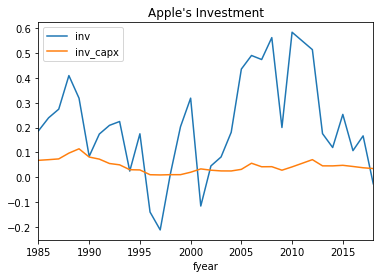

In [40]:
# Difference for Apple
compa.loc[(compa.gvkey=='001690')&(compa.fyear>=1985),['fyear','inv','inv_capx']].set_index(['fyear']).plot(title="Apple's Investment") 

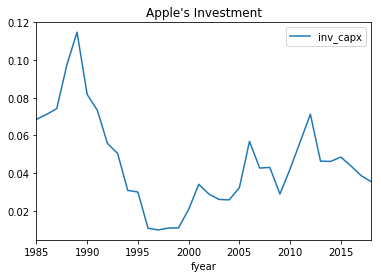

In [41]:
compa.loc[(compa.gvkey=='001690')&(compa.fyear>=1985),['fyear','inv_capx']].set_index(['fyear']).plot(title="Apple's Investment")

# Save Output

In [42]:
compa.columns

Index(['gvkey', 'datadate', 'conm', 'fyear', 'fyr', 'at', 'capx', 'ceq',
       'cogs', 'csho', 'dlc', 'dlcch', 'dltt', 'dp', 'ib', 'itcb', 'lt', 'mib',
       'naicsh', 'ni', 'prstkcc', 'pstk', 'pstkl', 'pstkrv', 're', 'revt',
       'sale', 'seq', 'sich', 'txdb', 'txdi', 'txditc', 'wcapch', 'xint',
       'xlr', 'xrd', 'xsga', 'se', 'ps', 'dt', 'be', 'cost', 'op', 'opbe',
       'at_lag', 'inv', 'fdiff', 'inv_capx'],
      dtype='object')

In [43]:
compa.to_pickle(path='C:/Users/lmota20/Dropbox/Columbia/BigData/class2019/Lecture_I/outputs/compa_annual.pkl')